In [1]:
01import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime as dt


In [2]:
path = "..\..\data\DEFRA\csv\DEFRA_5Y_Hourly.csv"
df = pd.read_csv(path,parse_dates=True,skiprows=3)


In [3]:
#gets the name/location of each sensor
sensorkeys = []
for col in df.columns:
    if "Birmingham" in col:
       sensorkeys.append((str(col)))

df = pd.read_csv(path,parse_dates=True,skiprows=4, low_memory=False)

In [4]:
#merging date and time + setting new index
df['Time'] = df['Time'].replace('24:00:00', '00:00')
df['DateTime']= pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.set_index('DateTime',inplace=True)
df.drop(['Date','Time'], axis=1,inplace=True)

#remove Nat Rows
df = df[:-4]

In [5]:
x = dt.datetime.strptime("00:00:00","%H:%M:%S").time()

#intialise empty dataframe
tempdf = pd.DataFrame

#subset midnight rows into new dataframe
tempdf = df.loc[df.index.time == x]
#drop midnight values from original 
df.drop(tempdf.index,inplace=True)
#increment day of midnights 
tempdf = tempdf.shift(1, freq='D')
#join the datframes together again
df = df.append(tempdf,verify_integrity=False)


In [6]:
columns = df.columns.to_list()
tempdf = df.filter(columns[:14])
tempdf2 = df.filter(columns[14:28])
tempdf3 = df.filter(columns[28:])

tempdf3.columns = tempdf2.columns = tempdf.columns

In [7]:
df = pd.DataFrame #intialise empty dataframe

#put each sensor data list into one concatenated dataframe
#df = pd.concat([tempdf,tempdf2,tempdf3], keys= sensorkeys)

#only get A4450 and Ladywood 
sensorkeys = sensorkeys[0],sensorkeys[2]
df = pd.concat([tempdf,tempdf2], keys= sensorkeys)

In [8]:
# dropping status columns (these columns just contain the unit of measure)
unitsList = []
for col in df.columns:
    if "Status" in col:
        unitsList.append(df[col][-1])
        df.drop(col,axis=1,inplace=True)

#replace strings for Null values with NaN 
df.replace("No data", np.nan, inplace=True)

#turn all data dtypes to numeric 
df = df.apply(pd.to_numeric)

columns = []
for i in range(len(df.columns)):
    col = df.columns[i]
    columns.append(col + " [" + unitsList[i] + "]")

#renaming the columns with the units of measure
df.columns = columns

#sort the datafarame index by datetime
df.sort_index(inplace=True)

# Time Series graphs

In [9]:
import plotly.graph_objects as go
import plotly.express as px

In [10]:
def createFigure(col,dft,keys):
    # Create figure
    fig = go.Figure()

    #look for each sensor data by its key
    for key in keys:
        df_t = dft.loc[str(key)]
        fig.add_trace(go.Scatter(x=list(df_t.index), y=list(df_t[col]), name= str(key)))

    # Set title
    fig.update_layout(
        title_text="Time series for %s measurements from DEFRA" % (col)
    )

    # Add range slider
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1d",
                        step="day",
                        stepmode="backward"),
                    dict(count=7,
                        label="1w",
                        step="day",
                        stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        yaxis=dict(
        autorange = True,
        fixedrange= False
        )
    )

    #fig.show()
    
    directory = "..\..\data\DEFRA\html\Hourly\%s.html" % (col)
    fig.write_html(directory) 

In [11]:
# for col in df.columns:
#     createFigure(col,df,sensorkeys)

# Correlations in data

In [12]:
tempdf = df.loc[sensorkeys[0]]
cor = tempdf.corr()

([<matplotlib.axis.XTick at 0x1ec2c2a16d0>,
 [Text(0, 1, 'Ozone [P ugm-3]'),
  Text(1, 1, 'Nitrogen dioxide [P ugm-3]'),
  Text(2, 1, 'PM10 particulate matter (Hourly measured) [P ugm-3 (FIDAS)]'),
  Text(3, 1, 'PM2.5 particulate matter (Hourly measured) [P ugm-3 (Ref.eq)]'),
  Text(4, 1, 'Modelled Wind Direction [N deg]'),
  Text(5, 1, 'Modelled Wind Speed [N ms-1]'),
  Text(6, 1, 'Modelled Temperature [N degC]')])

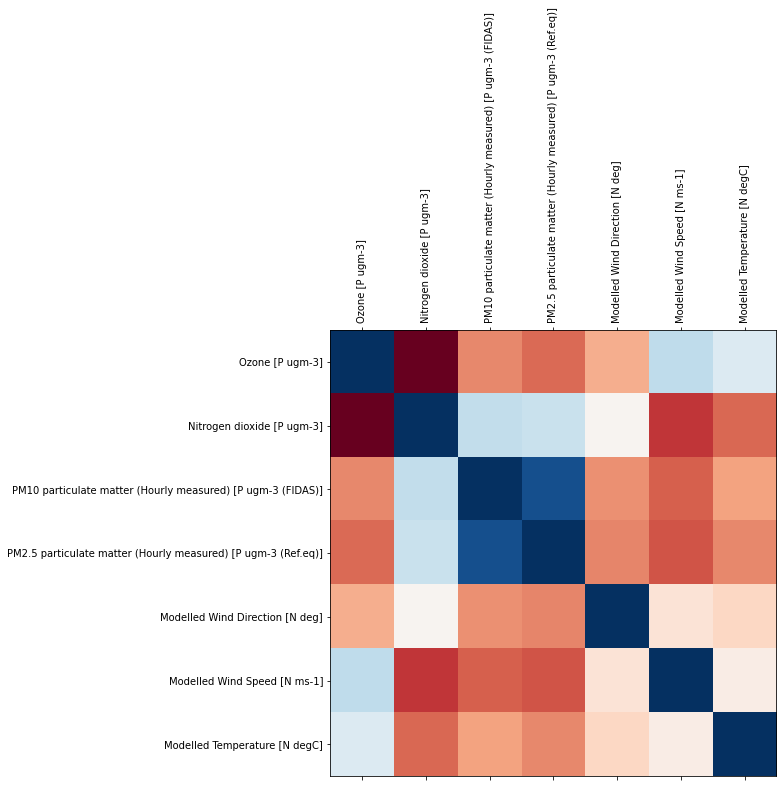

In [13]:
fig = plt.figure(figsize=(8,8))
plt.matshow(cor, cmap = 'RdBu', fignum = fig.number) #red (negative) / blue (postiive)
plt.yticks(range(len(cor.columns)), cor.columns)
plt.xticks(range(len(cor.columns)), cor.columns, rotation = "vertical")

In [14]:
cor

,Ozone [P ugm-3],Nitrogen dioxide [P ugm-3],PM10 particulate matter (Hourly measured) [P ugm-3 (FIDAS)],PM2.5 particulate matter (Hourly measured) [P ugm-3 (Ref.eq)],Modelled Wind Direction [N deg],Modelled Wind Speed [N ms-1],Modelled Temperature [N degC]
Ozone [P ugm-3],1.000000,-0.635625,-0.210298,-0.281307,-0.112196,0.387461,0.293889
Nitrogen dioxide [P ugm-3],-0.635625,1.000000,0.385053,0.362680,0.161269,-0.399361,-0.285250
PM10 particulate matter (Hourly measured) [P ugm-3 (FIDAS)],-0.210298,0.385053,1.000000,0.903882,-0.191832,-0.304066,-0.145640
PM2.5 particulate matter (Hourly measured) [P ugm-3 (Ref.eq)],-0.281307,0.362680,0.903882,1.000000,-0.214509,-0.332260,-0.210309
Modelled Wind Direction [N deg],-0.112196,0.161269,-0.191832,-0.214509,1.000000,0.069856,0.010521
Modelled Wind Speed [N ms-1],0.387461,-0.399361,-0.304066,-0.332260,0.069856,1.000000,0.123853
Modelled Temperature [N degC],0.293889,-0.285250,-0.145640,-0.210309,0.010521,0.123853,1.000000


In [15]:
# # Create figure
# fig = go.Figure()

# #look for each sensor data by its key
# for key in sensorkeys:
#     df_t = df.loc[str(key)]
#     fig.add_trace(go.Scatter(x=list(df_t.index), y=list(df_t['Ozone [V ugm-3]']), name= str(key) + 'Ozone [V ugm-3]'))
#     fig.add_trace(go.Scatter(x=list(df_t.index), y=list(df_t['Nitrogen dioxide [V ugm-3]']), name= str(key) + 'Nitrogen dioxide [V ugm-3]'))

# # Set title
# fig.update_layout(
#     title_text="Time series for Ozone and NO2 measurements from DEFRA"
# )

# # Add range slider
# fig.update_layout(
#     xaxis=dict(
#         rangeselector=dict(
#             buttons=list([
#                 dict(count=1,
#                     label="1d",
#                     step="day",
#                     stepmode="backward"),
#                 dict(count=7,
#                     label="1w",
#                     step="day",
#                     stepmode="backward"),
#                 dict(step="all")
#             ])
#         ),
#         rangeslider=dict(
#             visible=True
#         ),
#         type="date"
#     ),
#     yaxis=dict(
#     autorange = True,
#     fixedrange= False
#     )
# )

# fig.show()

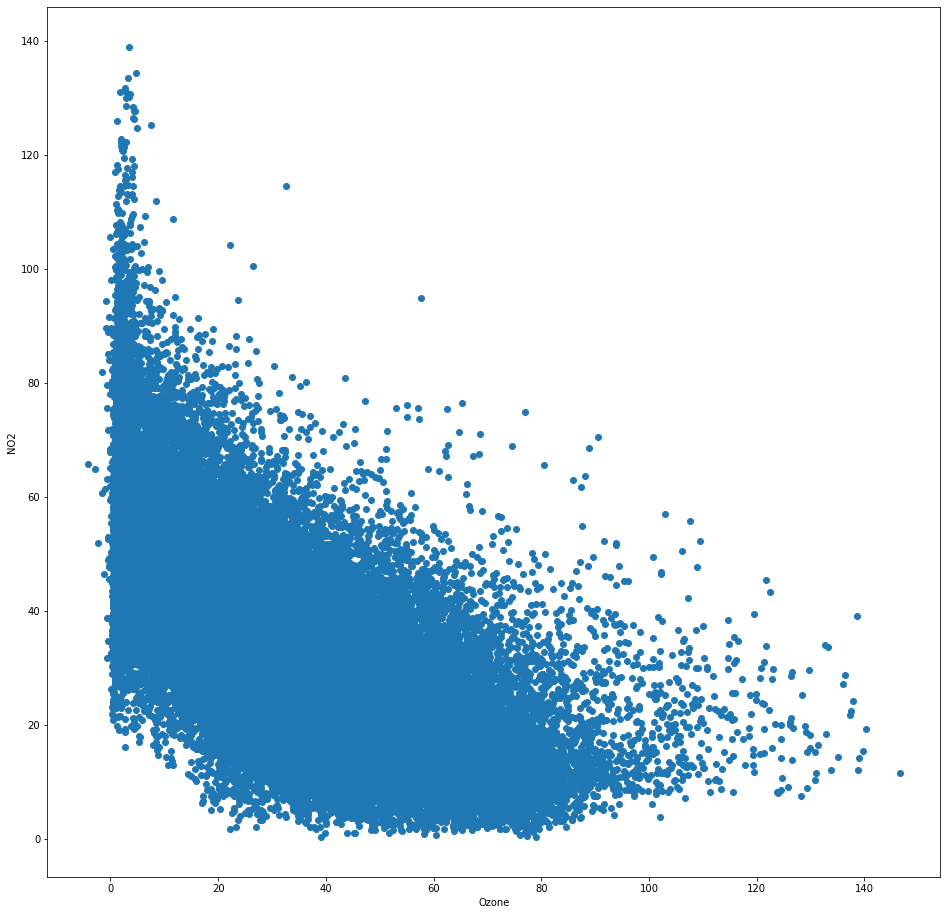

In [20]:
# fig, ax = plt.subplots(figsize = (16,16))
# ax.scatter(tempdf["Ozone [P ugm-3]"],tempdf["Nitrogen dioxide [P ugm-3]"])
# ax.set_ylabel("NO2")
# ax.set_xlabel("Ozone")
# plt.show()
